In [7]:
%pip install rdkit-pypi


[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import random
import os

# Set a random seed for reproducibility
random.seed(42)

# List of datasets to process
datasets = ['kiba', 'davis']

for dataset in datasets:
    # Step 1: Load the complete dataset
    df_train = pd.read_csv(f'data/{dataset}_train.csv')
    df_test = pd.read_csv(f'data/{dataset}_test.csv')
    
    # Combine train and test for blinding process
    complete_data = pd.concat([df_train, df_test], ignore_index=True)
    
    # Step 2: Save the original dataset
    original_data_path = f'data/{dataset}_original.csv'
    complete_data.to_csv(original_data_path, index=False)
    print(f'Original dataset saved at {original_data_path}.')

    # Step 3: Blinding the interactions
    # Choose a percentage of interactions to blind (e.g., 20%)
    blind_percentage = 0.2
    num_to_blind = int(len(complete_data) * blind_percentage)
    
    # Randomly select indices to blind
    indices_to_blind = random.sample(range(len(complete_data)), num_to_blind)
    
    # Create a new DataFrame for the blinded dataset
    blinded_data = complete_data.copy()
    
    # Set the affinity values for the selected indices to NaN
    blinded_data.loc[indices_to_blind, 'affinity'] = np.nan
    
    # Step 4: Save the blinded dataset
    blinded_data_path = f'data/{dataset}_blinded.csv'
    blinded_data.to_csv(blinded_data_path, index=False)
    print(f'Blinded dataset created for {dataset} with {num_to_blind} interactions blinded.')

    # Step 5: Prepare the validation and training datasets
    # Extract the blinded interactions for validation
    validation_data = blinded_data[blinded_data['affinity'].isna()]
    
    # Save the validation data
    validation_data_path = f'data/{dataset}_validation.csv'
    validation_data.to_csv(validation_data_path, index=False)
    print(f'Validation dataset saved at {validation_data_path}.')

    # Prepare the non-blinded data for training/testing
    non_blinded_data = blinded_data[blinded_data['affinity'].notna()]
    
    # Save the non-blinded data for processing by create_data.py
    non_blinded_data_path = f'data/{dataset}.csv'  # Will be used as input to create_data.py
    non_blinded_data.to_csv(non_blinded_data_path, index=False)
    print(f'Non-blinded dataset saved at {non_blinded_data_path} for processing.')

# Note: After running this script, run create_data.py to process the non-blinded data.

Original dataset saved at data/kiba_original.csv.
Blinded dataset created for kiba with 23650 interactions blinded.
Validation dataset saved at data/kiba_validation.csv.
Non-blinded dataset saved at data/kiba.csv for processing.
Original dataset saved at data/davis_original.csv.
Blinded dataset created for davis with 6011 interactions blinded.
Validation dataset saved at data/davis_validation.csv.
Non-blinded dataset saved at data/davis.csv for processing.


In [19]:
import os
import pandas as pd
import torch
import numpy as np
from create_data import smile_to_graph
from utils import TestbedDataset

seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:(i+1) for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000
def seq_cat(prot):
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

compound_iso_smiles = []
df = pd.read_csv('data/davis_validation.csv')
compound_iso_smiles += list( df['compound_iso_smiles'] )
compound_iso_smiles = set(compound_iso_smiles)
smile_graph = {}
for smile in compound_iso_smiles:
    g = smile_to_graph(smile)
    smile_graph[smile] = g

# Define the path for the validation data
validation_file = 'data/davis_validation.csv'
processed_validation_file = 'data/processed/davis_validation.pt'

# Check if the processed validation file already exists
if not os.path.isfile(processed_validation_file):
    # Load the validation dataset
    validation_df = pd.read_csv(validation_file)
    validation_drugs = validation_df['compound_iso_smiles'].values
    validation_prots = validation_df['target_sequence'].values
    validation_Y = validation_df['affinity'].values
    
    # Convert protein sequences using seq_cat (assuming this function exists)
    validation_encoded_prots = [seq_cat(t) for t in validation_prots]

    # Make the data ready for PyTorch Geometric
    print('Preparing validation_data.pt in PyTorch format!')
    validation_data = TestbedDataset(
        root='data',
        dataset='davis_validation',
        xd=validation_drugs,
        xt=validation_encoded_prots,
        y=validation_Y,
        smile_graph=smile_graph  # This assumes you've already created `smile_graph`
    )

    # Save the validation dataset
    torch.save(validation_data, processed_validation_file)
    print(f"{processed_validation_file} has been created")
else:
    print(f"{processed_validation_file} already exists")


data/processed/davis_validation.pt already exists


In [21]:
import torch
from torch_geometric.data import DataLoader
from models.ginconv import GINConvNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the validation dataset
validation_data = torch.load('data/processed/davis_validation.pt')

# Create a DataLoader for the validation dataset
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

# Define the model architecture (ensure this matches the one you used for training)
model = GINConvNet()  # or whichever model you used (e.g., GAT_GCN, GCNNet, etc.)

# Load the trained model weights (ensure the correct model path)
model_file_name = 'model_GINConvNet_davis.model'  # Update with your model file name
model.load_state_dict(torch.load(model_file_name))
model.eval()  # Set the model to evaluation mode

# Define a function to make predictions
def predict_affinities(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            batch_data = batch_data.to(device)  # Move data to the appropriate device
            output = model(batch_data)  # Forward pass to get predictions
            all_outputs.append(output.cpu().numpy())  # Store outputs (convert to numpy if needed)

    return np.concatenate(all_outputs)  # Concatenate outputs into a single array

# Run predictions on the validation data
outputs = predict_affinities(model, validation_loader)

# Print or save the predictions
print("Predictions on validation dataset:", outputs)


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_98175/2311854308.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  validation_data = torch.load('data/processed/

Predictions on validation dataset: [[4.8140316]
 [5.38923  ]
 [5.0319653]
 ...
 [7.3642497]
 [6.7440815]
 [5.2357283]]


In [35]:
%pip install seaborn



[notice] A new release of pip is available: 24.2 -> 24.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Mean Absolute Error (MAE): 0.7433822846843701
Mean Squared Error (MSE): 1.2666640004066538
R-squared (R²): -0.5867177897183811


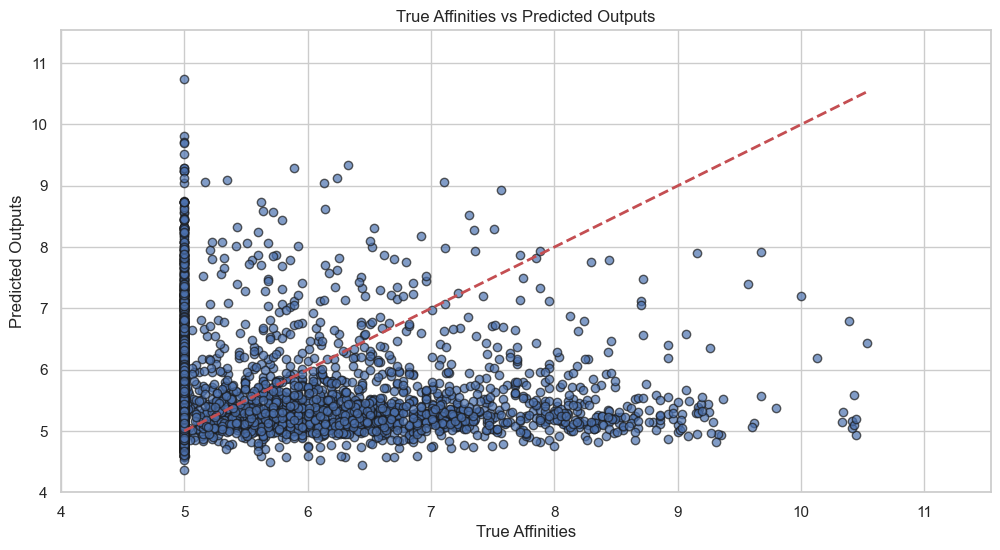

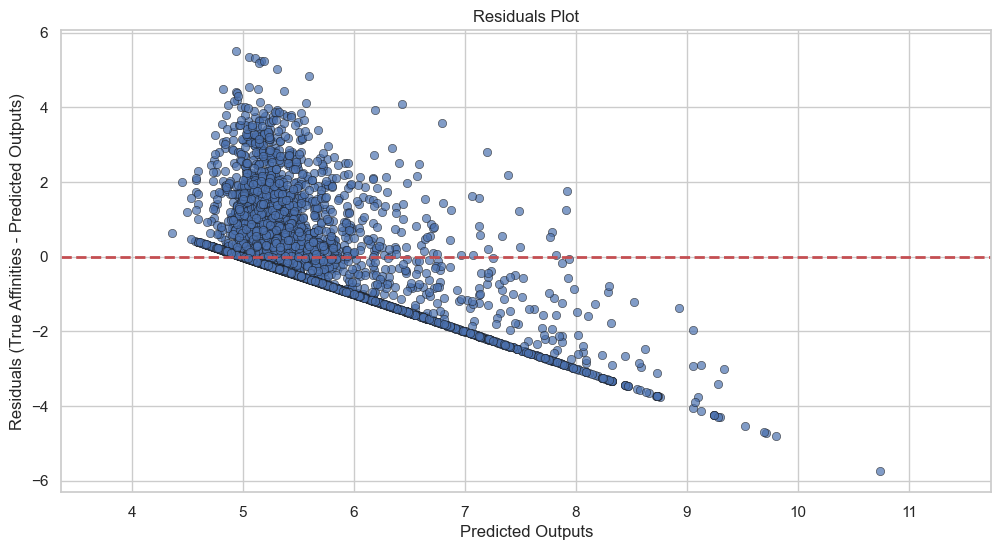

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Load the original data to get true affinity values
original_data = pd.read_csv('data/davis_original.csv')

# Step 2: Load the validation data
validation_data = pd.read_csv('data/davis_validation.csv')

# Step 3: Extract true affinity values from the original dataset
# Assuming 'indices_to_blind' is defined in your context
true_affinities = original_data.loc[indices_to_blind, 'affinity'].values

# 'outputs' is a numpy array of predicted affinity values
# For example:
# outputs = np.array([...])  # Your predicted affinity values

# Step 4: Calculate evaluation metrics
mae = mean_absolute_error(true_affinities, outputs)
mse = mean_squared_error(true_affinities, outputs)
r2 = r2_score(true_affinities, outputs)

# Step 5: Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

# Data Visualization

# Ensure that outputs and true_affinities are 1D arrays
outputs = np.ravel(outputs)  # Flatten outputs if necessary
true_affinities = np.ravel(true_affinities)  # Flatten true affinities if necessary

# Calculate residuals
residuals = true_affinities - outputs

# Set the style of seaborn
sns.set(style='whitegrid')

# Scatter plot: True vs Predicted Affinities
plt.figure(figsize=(12, 6))
plt.scatter(true_affinities, outputs, alpha=0.7, edgecolors='k')
plt.plot([true_affinities.min(), true_affinities.max()], 
         [true_affinities.min(), true_affinities.max()], 
         'r--', lw=2)  # Diagonal line for reference
plt.title('True Affinities vs Predicted Outputs')
plt.xlabel('True Affinities')
plt.ylabel('Predicted Outputs')
plt.xlim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.ylim(true_affinities.min() - 1, true_affinities.max() + 1)
plt.show()

# Residual plot: Errors
plt.figure(figsize=(12, 6))
sns.scatterplot(x=outputs, y=residuals, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line at zero for reference
plt.title('Residuals Plot')
plt.xlabel('Predicted Outputs')
plt.ylabel('Residuals (True Affinities - Predicted Outputs)')
plt.xlim(outputs.min() - 1, outputs.max() + 1)
plt.show()


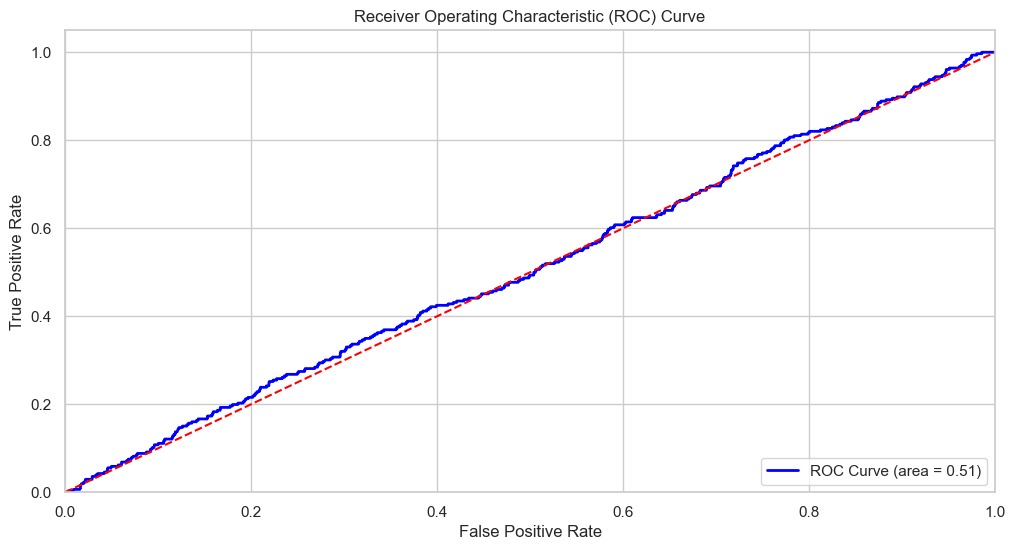

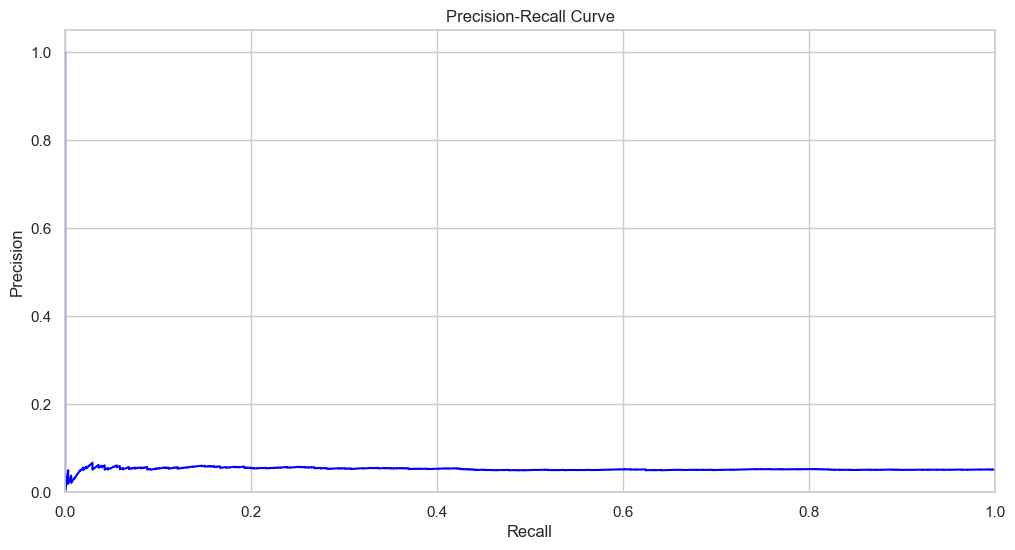

In [39]:
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve)
# ROC Curve
# For ROC curve, you need binary labels; let's assume you threshold the true affinities
threshold = 7.5  # Adjust based on your dataset
binary_true_affinities = (true_affinities > threshold).astype(int)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(binary_true_affinities, outputs)
roc_auc = roc_auc_score(binary_true_affinities, outputs)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(binary_true_affinities, outputs)
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()